# **SAMson: An Automated Brain Extraction Tool for Rodents Using SAM**  
*Accurate and robust rodent brain segmentation for MRI data*

---

### **Authored by**  
**Daniel Panadero Soler**<sup>1</sup>, **Mohamed Kotb Selim**<sup>1</sup>, **Patricia Martínez-Tazo**<sup>1</sup>,  
**Emma Muñoz-Moreno**<sup>2</sup>, **Pedro Ramos-Cabrer**<sup>3,4</sup>, **Pilar López-Larrubia**<sup>5</sup>,  
**Silvia De Santis**<sup>1</sup>, **Santiago Canals**<sup>1</sup>, and **Antonio Pertusa**<sup>6</sup>  

<sup>1</sup>Instituto de Neurociencias, CSIC-UMH, Sant Joan d’Alacant, Spain  
<sup>2</sup>IDIBAPS, Barcelona, Spain  
<sup>3</sup>CIC biomaGUNE, BRTA, Donostia–San Sebastián, Spain  
<sup>4</sup>Ikerbasque, Basque Foundation for Science, Bilbao, Spain  
<sup>5</sup>Instituto de Investigaciones Biomédicas Sols-Morreale, CSIC-UAM, Madrid, Spain  
<sup>6</sup>University Institute for Computer Research, University of Alicante, Alicante, Spain  

📧 **Contact**: [pertusa@ua.es](mailto:pertusa@ua.es)  

---

### **Abstract**  
Accurate brain extraction is a critical step in the analysis of rodent head magnetic resonance imaging (MRI) data. However, current methods often encounter difficulties in handling the diverse range of imaging setups, resolutions, and experimental conditions commonly found in this field.
SAMson (*SAM for Segmentation Of Neuroimages*) is an automated tool based on the Segment Anything Model (SAM), designed for robust rodent brain extraction. It integrates a bounding box generator and a mask prediction pipeline, offering fully automated and semi-automated modes to address varying experimental complexities.
SAMson has been evaluated using three multi-centre rodent MRI [datasets](https://doi.org/10.20350/digitalCSIC/17000)  annotated at the pixel level, differing in acquisition parameters, resolution, and animal age groups. The tool demonstrates superior performance to existing methods (BET, RBM, BEN) in terms of segmentation accuracy, with Jaccard indices exceeding 90% across datasets. Its semi-automated mode is particularly effective in challenging scenarios such as low-resolution images and cases requiring refined mask precision.
By identifying errors at the individual slice level, SAMson enables rapid and targeted corrections, advancing translational neuroscience by supporting large-scale research workflows.  

---

### **Getting Started**  
To begin using SAMson, follow these steps:  
1. Install the required dependencies. Download [SAM's ViT-H model checkpoint](https://github.com/facebookresearch/segment-anything?tab=readme-ov-file#model-checkpoints) and the [Mouse-X template](https://doi.org/10.20350/digitalCSIC/17000).
2. Place your MR images in a folder, ensuring they are in NIfTI format.
3. Execute the provided initialization cells, following the usage instructions in the comments.
4. Run the fully automated mode for straightforward datasets or the semi-automated mode for challenging cases.
5. If manual masks are available, use the provided functions to assess segmentation accuracy.



## Setup

In [1]:
import os                                                                       # files
import time                                                                     # progress
import cv2                                                                      # images
import matplotlib.pyplot as plt                                                 # plots
import numpy as np                                                              # arrays
import nibabel as nib                                                           # nifti
from os.path import join as pjoin                                               # join paths
from segment_anything import sam_model_registry, SamPredictor                   # SAM
from skimage.morphology import binary_closing, binary_erosion, binary_dilation  # mask processing
from scipy import ndimage                                                       # image processing
from dipy.segment.mask import median_otsu                                       # Otsu method
import torch
torch.cuda.empty_cache()

"""""  INPUTS  (ADAPT  FOLLOWING  LINES)  """""

# ------------------           PATHS           ------------------ #
template_path = r"/home/dpanadero/Documents/2_automask/data/anat_template_FP.nii"  # Path to template file
subjects_path = r"/home/dpanadero/Documents/2_automask/data/subjects"              # Path to folder with all subjects NIfTI files
output_path_b = r"/home/dpanadero/Documents/2_automask/output"                     # Path to all outputs folder

# ----------------    ANTERO-POSTERIOR RANGE     ---------------- #
initial_slice =  8  # Index of the template slice that best matches your image's initial slice
final_slice   = 31  # Index of the template slice that best matches your image's final slice

"""""""""   SEGMENT  ANYTHING  MODEL   """""""""

sam_checkpoint = "sam_vit_h_4b8939.pth"  # Path to SAM model file
model_type     = "vit_h"
device         = "cuda"  # Use "cpu" if GPU is not available
sam            = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device  = device)
predictor      = SamPredictor(sam)

/opt/apps/conda/dpanadero/envs/samson_test2/lib/python3.10/site-packages/segment_anything/build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.

In [2]:

"""""""""       SIMPLE  FUNCTIONS       """""""""

# Plot SAM's input box
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h   = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))

# Plot SAMson and reference masks (different colors)
def show_mask(mask, ax, manual=False):
    if manual:
        color = np.array([255/255, 234/255,   0/255, 0.6])  # Yellow for reference masks
    else:
        color = np.array([ 30/255, 144/255, 255/255, 0.6])  # Blue for SAMson-generated masks
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def print_percent_done(index, total, bar_len=20):
    """
    Display a dynamic progress bar in the console.

    Parameters:
    - index (int): The current iteration index (0-based).
    - total (int): The total number of iterations or steps.
    - bar_len (int): The length of the progress bar (default is 20 characters).

    Notes:
    - The function calculates the percentage of completion based on the current index and total.
    - The progress bar dynamically updates on the same line using the carriage return ('\r').
    - A completion symbol ('✅') is displayed when 100% is reached.
    """
    # Calculate percentage done
    percent_done = (index + 1) / total * 100
    percent_done = round(percent_done, 1)  # Round to 1 decimal place

    # Determine the number of completed and remaining segments in the bar
    done = round(percent_done / (100 / bar_len))
    togo = bar_len - done

    # Construct the progress bar string
    done_str = '◼' * int(done)  # Filled part of the bar
    togo_str = ' ' * int(togo)  # Empty part of the bar

    if percent_done < 100:
        # Print the progress bar with percentage, overwriting the same line
        print(f'\u23F3  [{done_str}{togo_str}] {percent_done}%', end='\r')
    else:  # If the process is complete, print the completion symbol
        print(f'✅  [{done_str}{togo_str}] {percent_done}%', end=' ')

def evaluate(mask_sam, mask_image, slice_index, accuracies, jaccards, dices, sam_list=False):
    """
    Compute performance metrics for generated masks compared to reference masks.

    Parameters:
    - mask_sam (np.ndarray): The binary mask generated by SAM.
    - mask_image (np.ndarray): The binary reference mask for comparison.
    - slice_index (int): The index of the current slice being evaluated.
    - accuracies (list): A list to store accuracy metrics for each slice.
    - jaccards (list): A list to store Jaccard index metrics for each slice.
    - dices (list): A list to store Dice coefficient metrics for each slice.
    - sam_list (bool): If True, print all three values in a single line; if False, print one value.

    Notes:
    - Accuracy is calculated as the percentage of correctly segmented pixels.
    - Jaccard Index measures overlap between SAM and reference masks.
    - Dice Coefficient is another measure of overlap but emphasizes agreement.
    - If the reference mask or SAM mask is empty, metrics default to 0.
    """
    # Convert masks to integer format for computation
    sam_int = mask_sam.astype(int)
    ref_int = mask_image.astype(int)

    # Compute difference and total sum between SAM and reference masks
    diff = ref_int - sam_int
    total = ref_int + sam_int

    # Calculate metrics if reference mask or SAM mask is not empty
    if np.any(ref_int) and np.any(total):
        acc = 100 - round((np.count_nonzero(diff) / np.count_nonzero(ref_int)) * 100, 2)
        jaccard = round((np.count_nonzero(total == 2) / np.count_nonzero(total)), 4)
        dice = round(2 * (np.count_nonzero(total == 2) / (np.count_nonzero(sam_int) + np.count_nonzero(ref_int))), 4)
    else:
        acc, jaccard, dice = 0, 0, 0

    # Print metrics based on the sam_list flag
    if not sam_list:
        print(f"Accuracy of slice #{slice_index + 1}: {acc}%")
    else:
        print(f"\t{slice_index + 1}: {acc}%", end="\t")

    # Append metrics to their respective lists
    accuracies.append(acc)
    jaccards.append(jaccard)
    dices.append(dice)

def remove_separate_pixels(mask):
    """
    Remove all disconnected pixel groups in the mask except the largest connected component.

    Parameters:
    mask (np.ndarray): A binary mask (2D array) with disconnected regions.

    Returns:
    mask (np.ndarray): A binary mask containing only the largest connected component.

    Notes:
    - Uses labeling to identify distinct regions in the mask.
    - Retains the region with the largest size and removes all others.
    """
    # Label and count disconnected regions in the mask
    labeled_array, num_features = ndimage.label(mask)

    # Find the size of each region and identify the largest region
    region_sizes = np.bincount(labeled_array.ravel())
    largest_label = np.argmax(region_sizes[1:]) + 1

    # Generate a mask for the largest connected component
    largest_component_mask = labeled_array == largest_label

    # Return the updated mask containing only the largest component
    return np.where(largest_component_mask, 1, 0)

def remove_lobes_and_separate_pixels(mask, otsu=False):
    """
    Remove lobes and isolated pixel groups from a binary mask.

    Parameters:
    - mask (np.ndarray): A binary mask (2D array) with lobes and disconnected regions.
    - otsu (bool): If True, use larger footprints for erosion; otherwise, use smaller footprints.

    Returns:
    mask (np.ndarray): A cleaned binary mask with lobes removed and only the largest connected component retained.

    Notes:
    - Lobes are identified by iterative erosion and dilation processes.
    - After removing lobes, the mask is processed to retain only the largest connected component.
    """
    if np.any(mask):
        if otsu:
            footprint_size_range = [2,5,20]
        else:
            footprint_size_range = [1,2,3]
        for i in footprint_size_range:
            mask_erd = binary_erosion(mask, footprint = np.ones((i, i))) # Mask erosion
            if np.any(mask_erd):     
                
                # Turn to 0 all pixels in biggest group of eroded mask
                labeled_array, num_features = ndimage.label(mask_erd)
                region_sizes  = np.bincount(labeled_array.ravel())
                largest_label = np.argmax(region_sizes[1:]) + 1
                largest_component_mask = labeled_array == largest_label
                result_array  = mask_erd.copy()
                result_array[largest_component_mask] = 0
                
                # Dilate detected lobes
                result_array_dil = binary_dilation(result_array, footprint = np.ones((i, i)))
                
                # Subtract lobes from original mask
                mask = np.where(mask == True, 1, 0)
                result_array_dil = np.where(result_array_dil == True, 1, 0)
                mask_final = mask - result_array_dil
            else:
                mask_final = mask
            mask = remove_separate_pixels(mask_final)
    return mask

def find_best_mask_indexes(accuracy_list, m, n):
    """
    Find the best mask for each slice in each volumetric image.

    Parameters:
    - accuracy_list (list): A flat list of accuracies (size: m * n * 3).
    - m (int): Number of volumetric images.
    - n (int): Number of slices per volumetric image.

    Returns:
    best_mask_indexes (list of lists): Each inner list represents a volumetric image, containing
                                       the index of the best mask (0, 1, or 2) for each slice.
    """
    # Initialize the output list for m volumetric images
    best_mask_indexes = []

    # Iterate over each volumetric image
    for i in range(m):
        # Initialize the list for the current volumetric image
        image_best_masks = []

        # Iterate over each slice in the current volumetric image
        for j in range(n):
            # Calculate the starting index for the 3 accuracies of the current slice
            slice_start_index = (i * n + j) * 3

            # Get the accuracies for the three masks of this slice
            slice_accuracies = accuracy_list[slice_start_index:slice_start_index + 3]

            # Find the index of the best accuracy (0, 1, or 2)
            best_mask_index = slice_accuracies.index(max(slice_accuracies))

            # Append the best mask index to the list for this image
            image_best_masks.append(best_mask_index)

        # Append the list for the current image to the overall result
        best_mask_indexes.append(image_best_masks)

    return best_mask_indexes


"""""""""       COMPLEX  FUNCTIONS       """""""""

def create_sam_candidates_list(file, semi_auto=False, reference_mask=False, reorient=True):
    """
    Generate a list of SAMson outputs for a given rodent brain subject.

    Parameters:
    - file (str): Filename of the subject's NIfTI image.
    - semi_auto (bool): If True, enables generating 3 predictions per slice (semi-automatic).
    - reference_mask (bool): If True, compares results against a reference mask for performance evaluation.
    - reorient (bool): Set to True if the anteroposterior axis orientation goes from rostral to caudal.

    Returns:
    sam_mask_list (list): List of SAM-generated binary masks for each slice.

    Notes:
    - Generates initial input boxes using Otsu thresholding.
    - The process includes performance evaluation if a reference mask is provided.
    - Visualization of segmentation results is done at the end.
    """
    # Load subject image
    subject = nib.load(pjoin(subjects_path, file)).get_fdata()
    if reorient: subject = np.flip(subject,axis=2)  # If anteroposterior orientation goes from rostral to caudal

    start_time = time.time()

    # Automatically generate input boxes using Otsu method
    median_radius, numpass = (2, 5) if subject.shape[1] < 140 else (1,3) # Default values for lower-resolution, else higher-resolution
    boxes, mask_otsu = generate_boxes(file, median_radius, numpass, reorient=reorient)

    print(f'✅ Automatic generation of input boxes completed in {round((time.time() - start_time) / 60, 2)} minutes')

    sam_mask_list = []
    start_time = time.time()

    # Process each slice for SAM model predictions
    for slice_index in range(subject.shape[2]):
        print_percent_done(slice_index, subject.shape[2])  # Show progress
        time.sleep(0.02)  # Avoid overloading the console

        # Extract the current slice and preprocess it
        box = np.array(boxes[slice_index])
        image = np.rot90(subject[:, :, slice_index]).astype(np.float32)  # Rotate and cast to float32 for processing
        image_norm = (image / np.max(image)) * 255  # Normalize image to 0-255 for SAM model input
        image = cv2.cvtColor(image_norm.astype(np.uint8), cv2.COLOR_GRAY2RGB)  # Convert to RGB for SAM

        # Predict segmentation masks using SAM model
        predictor.set_image(image)
        masks, scores, logits = predictor.predict(
            point_coords=None, point_labels=None, box=box[None, :], multimask_output=semi_auto
        )

        # Post-process and store the masks
        for mask, score in zip(masks, scores):
            mask = remove_lobes_and_separate_pixels(mask)  # Remove irrelevant regions and split connected areas
            mask = binary_closing(mask, footprint=np.ones((2, 2)))  # Apply closing operation to smooth masks
            sam_mask_list.append(mask)

    # Print time taken for extraction
    print(f" - extraction completed in {round((time.time() - start_time) / 60, 2)} minutes")

    # Plot results (optional reference mask evaluation)
    plot_results(file, semi_auto=semi_auto, sam_mask=False, reference_mask=reference_mask, sam_list=sam_mask_list, reorient=reorient)

    return sam_mask_list

def create_sam_masks_nifti(file, sam_mask_list, best_mask_index=False, reference_mask=False, reorient=True):
    """
    Select the best SAM mask for each slice and save the results as a NIfTI file.

    Parameters:
    - file (str): Filename of the subject's NIfTI image.
    - sam_mask_list (list): List containing SAM-generated binary masks for each slice.
    - best_mask_index (list or bool): If provided, selects the best mask for each slice based on index.
    - reference_mask (bool): If True, compares results against a reference mask for performance evaluation.
    - reorient (bool): Set to True if the anteroposterior axis orientation goes from rostral to caudal.

    Returns:
    None: Saves the generated masks as a NIfTI file in the specified output path.

    Notes:
    - The selected masks are geometrically aligned with the original subject image.
    - The function visualizes results and saves the final mask as a NIfTI file.
    """
    # Load the subject's NIfTI image and extract data
    subject_nifti = nib.load(pjoin(subjects_path, file))  # Subject image
    subject = subject_nifti.get_fdata()
    if reorient: subject = np.flip(subject,axis=2)  # If anteroposterior orientation goes from rostral to caudal

    # List to store selected SAM masks for each slice
    sam_mask_list_selection = []

    # Loop through each slice and select the best mask
    for slice_index in range(subject.shape[2]):
        if best_mask_index:  # If best_mask_index is provided, select the specified mask
            mask = sam_mask_list[slice_index * 3 + best_mask_index[slice_index]]
        else:  # Otherwise, take the first available mask for this slice
            mask = sam_mask_list[slice_index]
        sam_mask_list_selection.append(mask)

    # Convert selected masks list into a geometrically consistent NIfTI object
    array = np.array(sam_mask_list_selection)
    array = np.transpose(array, (2, 1, 0))  # Transpose to match the subject's original shape (108, 90, 16)
    array = np.rot90(array, k=2)  # Rotate 180 degrees to ensure correct orientation
    array = np.flip(array, axis=0)  # Flip along the vertical axis to align with subject's orientation
    array = array.astype('float64')  # Convert to float64 for NIfTI storage compatibility

    # Create the NIfTI image object
    masks_nifti = nib.Nifti1Image(array, affine=subject_nifti.affine)  # Using subject's affine matrix

    # Save the generated masks as a NIfTI file in the specified output path
    nib.save(masks_nifti, pjoin(output_path, f'{file.split(".")[0]}_mask.nii.gz'))  # SAMson mask image output

    # Visualize the results (optional reference mask evaluation)
    plot_results(file, semi_auto=best_mask_index, reference_mask=reference_mask, reorient=reorient)

def plot_results(file, semi_auto=False, sam_mask=True, reference_mask=False, show_boxes=True, sam_list=False, reorient=True):
    """
    Plot SAM masks, reference masks, input boxes, and compute evaluation metrics.

    Parameters:
    - file (str): Subject's NIfTI image filename.
    - semi_auto (bool): Display 3 predictions per slice.
    - sam_mask (bool): Plot SAM-generated mask.
    - reference_mask (bool): Plot reference mask.
    - show_boxes (bool): Display bounding boxes for each slice.
    - sam_list (bool): Plot all SAM outputs (if True).
    - reorient (bool): Set to True if the anteroposterior axis orientation goes from rostral to caudal.

    Returns:
    - None (Displays the plots and optionally computes evaluation metrics).
    """
    # Load subject and reference masks, and boxes
    subject = nib.load(pjoin(subjects_path, file)).get_fdata()
    if reorient: subject = np.flip(subject,axis=2)  # If anteroposterior orientation goes from rostral to caudal
    mask = nib.load(pjoin(output_path, f'{file.split(".")[0]}_mask.nii.gz')).get_fdata() if sam_mask else None
    ref_mask = nib.load(pjoin(subjects_path, f'manual_masks/{file[:7]}_mask_{file[17:-4]}.nii')).get_fdata() if reference_mask else None
    median_radius, numpass = (2, 5) if subject.shape[1] < 140 else (1,3) # Default values for lower-resolution, else higher-resolution
    boxes, mask_otsu = generate_boxes(file, numpass, median_radius, reorient=reorient) if show_boxes else (None, None)

    # Initialize evaluation metrics if masks are available
    evaluation = (sam_mask and reference_mask) or (sam_list and reference_mask)
    accuracies, jaccards, dices = [], [], [] if evaluation else [None] * 3

    # Loop over slices
    for slice_index in range(subject.shape[2]):
        image = np.rot90(subject[:, :, slice_index]).astype(np.float32)
        image = cv2.cvtColor(((image / np.max(image)) * 255).astype(np.uint8), cv2.COLOR_GRAY2RGB)

        # Get current slice masks and boxes
        mask_image = np.rot90(mask[:, :, slice_index]) if sam_mask else None
        ref_mask_image = np.rot90(ref_mask[:, :, slice_index]) if reference_mask else None
        box = np.array(boxes[slice_index]) if show_boxes else None
        
        # Plot SAMson outputs in files and/or reference masks and/or generated bounding boxes
        if sam_mask or (reference_mask and not sam_list) or (show_boxes and not sam_list) or (not sam_mask and not reference_mask and not show_boxes):
            # Perform evaluation if needed
            if evaluation:
                evaluate(mask_image, ref_mask_image, slice_index, accuracies, jaccards, dices)
    
            # Create the plot
            plt.figure(dpi=70)
            plt.title(f"Slice #{slice_index+1}")
            plt.imshow(image)
            plt.axis('off')
    
            # Overlay masks and boxes
            if reference_mask: show_mask(ref_mask_image, plt.gca(), manual=True)
            if sam_mask: show_mask(mask_image, plt.gca())
            if show_boxes: show_box(box, plt.gca())
    
            # Show the plot for each slice
            plt.show()

        # Plot all SAMson outputs in list
        if sam_list:
            fig, ax = plt.subplots(1, 3, figsize=(7, 11)) if semi_auto else plt.subplots(dpi=50)
            for i in range(3 if semi_auto else 1):
                sam_img = sam_list[slice_index * 3 + i] if semi_auto else sam_list[slice_index]
                if evaluation: evaluate(sam_img, ref_mask_image, slice_index, accuracies, jaccards, dices, sam_list=True)
                ax[i].imshow(image) if semi_auto else ax.imshow(image)
                ax[i].set_title(f"Slice #{slice_index+1} - {i+1}", fontsize=10) if semi_auto else ax.set_title(f"Slice #{slice_index+1}", fontsize=10)
                ax[i].axis('off') if semi_auto else ax.axis('off')
                if reference_mask: show_mask(ref_mask_image, ax[i], manual=True) if semi_auto else show_mask(ref_mask_image, plt.gca(), manual=True)
                show_mask(sam_img, ax[i]) if semi_auto else show_mask(sam_img, plt.gca())
                if show_boxes: show_box(box, ax[i]) if semi_auto else show_box(box, plt.gca())
            if semi_auto: plt.tight_layout()
            plt.show()

    # Compute and print evaluation metrics if applicable
    if evaluation:
        print("Subject mean performance metrics:")
        print(f"Accuracy:\t\t {round(sum(accuracies) / len(accuracies), 2)}%")
        print(f"Jaccard index:\t\t {round(sum(jaccards) / len(jaccards), 4)}")
        print(f"Dice coefficient:\t {round(sum(dices) / len(dices), 4)}")

        # Store per-slice metrics
        for i in range(len(accuracies)):
            accuracies_per_slice.append(accuracies[i])
            jaccards_per_slice.append(jaccards[i])
            dices_per_slice.append(dices[i])

        # Store mean metrics across slices
        mean_accuracies.append(round(sum(accuracies) / len(accuracies), 2))
        mean_jaccards.append(round(sum(jaccards) / len(jaccards), 4))
        mean_dices.append(round(sum(dices) / len(dices), 4))


### Input prompt generation

In [3]:
def generate_boxes_from_template(template_path):
    """
    Generates bounding boxes for each slice of a template NIfTI image.

    Parameters:
    - template_path (str): Path to the template NIfTI file.

    Returns:
    - template_boxes_edges (list of lists): Bounding boxes for each slice of the template.
    - relative_coordinates (list of lists): Relative coordinates of boxes in all templates slices with 
                                            respect to the box in the template central slice.
    """
    # Load the NIfTI file and extract image data and dimensions
    template_nifti = nib.load(template_path)
    template_data = template_nifti.get_fdata()
    num_slices = template_nifti.header.get_data_shape()[2]

    # Store bounding box edges for each slice
    template_boxes_edges = []

    for i in range(num_slices):
        # Rotate the slice for consistent orientation
        slice_data = np.rot90(template_data[:, :, i])
        output_array = np.zeros_like(slice_data)

        # Identify non-zero indices in the slice (values > 0.5)
        non_zero_indices = np.argwhere(slice_data > 0.5)
        if len(non_zero_indices):
            # Compute bounding box around non-zero regions
            min_row, min_col = np.min(non_zero_indices, axis=0)
            max_row, max_col = np.max(non_zero_indices, axis=0)
            output_array[min_row:max_row + 1, min_col:max_col + 1] = 1
            output_array = output_array.astype(int)

        # Calculate bounding box edges coordinates
        bbox_indices = np.argwhere(output_array != 0)
        if np.any(bbox_indices):
            yu, xl = np.min(bbox_indices, axis=0)
            yd, xr = np.max(bbox_indices, axis=0)
            template_boxes_edges.append([xl, yu, xr, yd])
        else:
            # Default box if no region found
            template_boxes_edges.append([0, 0, 0, 0])

    # Compute central slice index
    central_slice_index = round(num_slices/2)

    # Dimensions of the bounding box on the central slice of the template
    central_box = template_boxes_edges[central_slice_index]
    width_x   = central_box[2] - central_box[0]
    width_y   = central_box[3] - central_box[1]
    central_x = central_box[0] + width_x / 2
    central_y = central_box[1] + width_y / 2

    # Compute relative coordinates for each slice of the template
    relative_coordinates = []
    for bbox in template_boxes_edges:
        p_x_left  = (central_x - bbox[0]) / width_x
        p_x_right = (bbox[2] - central_x) / width_x
        p_y_up    = (central_y - bbox[1]) / width_y
        p_y_down  = (bbox[3] - central_y) / width_y
        relative_coordinates.append([p_x_left, p_y_up, p_x_right, p_y_down])

    return template_boxes_edges, relative_coordinates

template_boxes_edges, relative_coordinates = generate_boxes_from_template(template_path)

def generate_boxes(file, median_radius, numpass, reorient=True):
    """
    Generates bounding boxes for each slice of a subject image using interpolation of 
    template-based bounding box coordinates and a central slice box derived from the Otsu mask.

    Parameters:
    - file (str): File name of the subject NIfTI image.
    - median_radius (int): Radius for median filter in median_otsu function.
    - numpass (int): Number of passes for median_otsu function.
    - reorient (bool): Set to True if the anteroposterior axis orientation goes from rostral to caudal.

    Returns:
    - boxes_edges (list of lists): Bounding box edges for each slice in the format [x_left, y_up, x_right, y_down].
    - mask (np.ndarray): Binary mask of the subject after applying median_otsu.
    """
    boxes_edges = []

    # Load the subject NIfTI file and extract data
    subject = nib.load(pjoin(subjects_path, file)).get_fdata()
    subject_number_of_slices = subject.shape[2]
    template_nifti = nib.load(template_path)
    template_number_of_slices = template_nifti.header.get_data_shape()[2]

    if reorient: subject = np.flip(subject,axis=2)  # If anteroposterior orientation goes from rostral to caudal
    # Handle 4D data by squeezing out singleton dimensions
    if len(subject.shape) > 3:
        subject = np.squeeze(subject, axis=-1)

    # Generate z-coordinates for subject and template slices
    z_template = np.linspace(0, 1, template_number_of_slices)
    z_subject = np.linspace(z_template[initial_slice], z_template[final_slice], subject_number_of_slices)

    # Find the central slice index for the subject
    central_slice_index_subject = np.abs(z_subject - 0.5).argmin()

    # Interpolate bounding box coordinates for the subject
    interpolated_coordinates = []
    for z in z_subject:
        previous_index = np.searchsorted(z_template, z, side='right') - 1
        next_index     = np.searchsorted(z_template, z, side='left')

        if previous_index == next_index:
            # Use nearest template slice if z aligns exactly
            interpolated_coordinates.append(relative_coordinates[np.abs(z_template - z).argmin()])
        else:
            # Linearly interpolate between the two nearest template slices
            prev_weights = np.array(relative_coordinates[previous_index])
            next_weights = np.array(relative_coordinates[next_index])
            interpolated_coordinates.append(list(prev_weights + (z - z_template[previous_index]) * (
                (next_weights - prev_weights) / (z_template[next_index] - z_template[previous_index]))))

    # Apply median_otsu to obtain the binary mask
    _, mask = median_otsu(subject, median_radius=median_radius, numpass=numpass)

    # Process the central slice to calculate its bounding box
    central_slice_mask = np.rot90(mask[:, :, central_slice_index_subject])
    central_slice_mask = remove_lobes_and_separate_pixels(central_slice_mask, otsu=True)
    indices = np.argwhere(central_slice_mask != 0)

    if np.any(indices):
        # Compute bounding box edges for the central slice of the subject
        yu, xl = np.min(indices, axis=0)
        yd, xr = np.max(indices, axis=0)
        central_slice_box_edges = [xl, yu, xr, yd]
    else:
        # Default to an empty bounding box if no valid region is found
        central_slice_box_edges = [0, 0, 0, 0]

    # Calculate dimensions and center of the central slice bounding box of the subject
    width_x   = central_slice_box_edges[2] - central_slice_box_edges[0]
    width_y   = central_slice_box_edges[3] - central_slice_box_edges[1]
    central_x = central_slice_box_edges[0] + width_x / 2
    central_y = central_slice_box_edges[1] + width_y / 2

    # Generate bounding boxes for all subject slices based on interpolated coordinates
    for i in range(subject_number_of_slices):
        xl = central_x - width_x * interpolated_coordinates[i][0]
        xr = central_x + width_x * interpolated_coordinates[i][2]
        yu = central_y - width_y * interpolated_coordinates[i][1]
        yd = central_y + width_y * interpolated_coordinates[i][3]
        box_edges = [xl, yu, xr, yd]
        boxes_edges.append(box_edges)

    return boxes_edges, mask

## Full-Auto

List of files to segment:

merge_C230524_ses-01_run-02_T2w.nii.gz

-------------------------------------------------

Subject filename:  merge_C230524_ses-01_run-02_T2w.nii.gz 

✅ Automatic generation of input boxes completed in 0.01 minutes
✅  [◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼] 100.0%  - extraction completed in 0.15 minutes


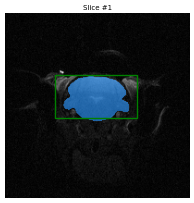

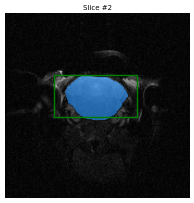

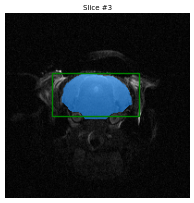

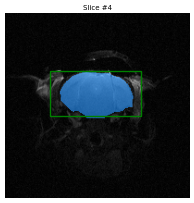

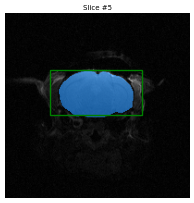

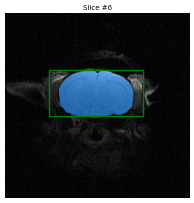

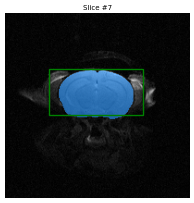

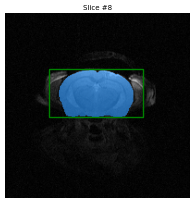

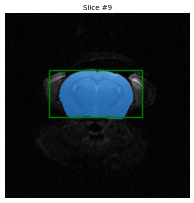

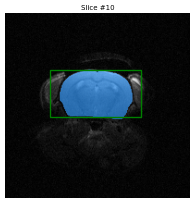

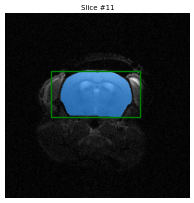

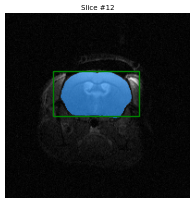

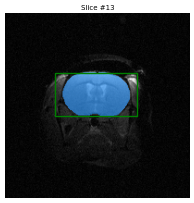

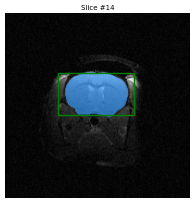

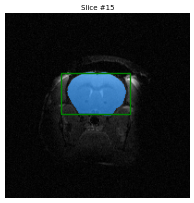

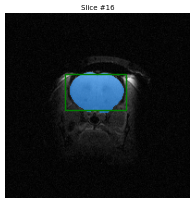

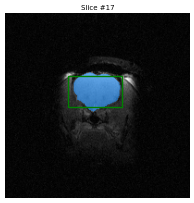

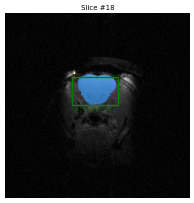

In [4]:
# Create a list of image files for segmentation
files = []
subjects_path, output_path = subjects_path, pjoin(output_path_b,"full_auto")
os.makedirs(pjoin(output_path), exist_ok=True)
print("List of files to segment:\n")
for file in sorted(os.listdir(subjects_path)):
    if file.endswith("nii") or file.endswith("nii.gz"):  # Adapt filename conditions
        files.append(file)
        print(file)
        
# Generate SAMson masks and visualize the corresponding predictions
list_of_sam_mask_lists = []

for file in files:
    print("\n-------------------------------------------------\n")
    print("Subject filename: ",file,"\n")
    sam_mask_list = create_sam_candidates_list(file)    
    list_of_sam_mask_lists.append(sam_mask_list)


-------------------------------------------------

Subject filename:  merge_C230524_ses-01_run-02_T2w.nii.gz 



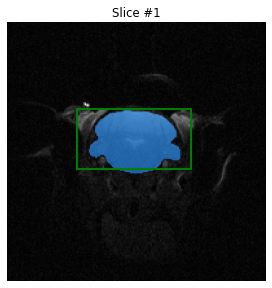

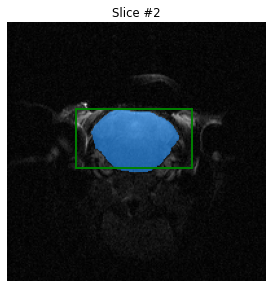

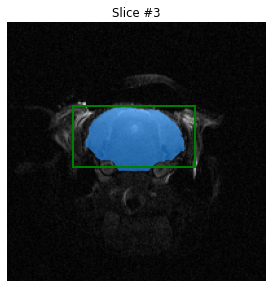

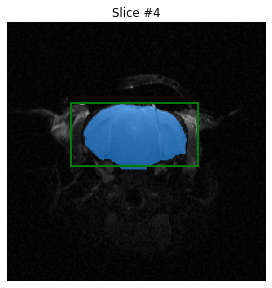

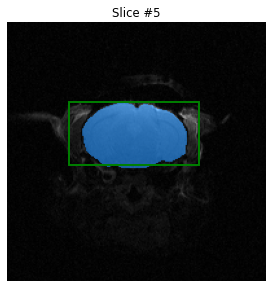

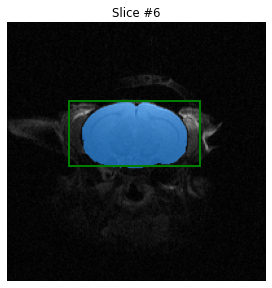

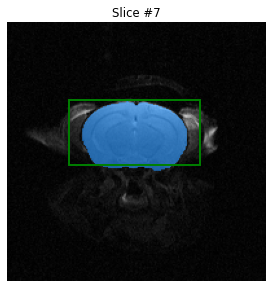

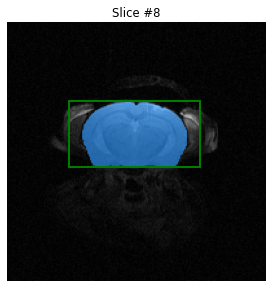

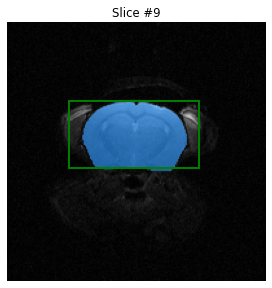

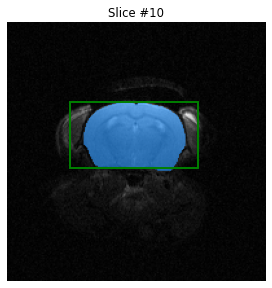

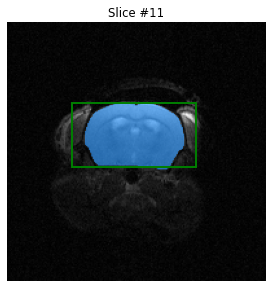

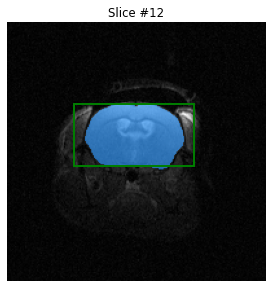

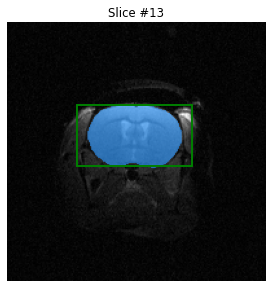

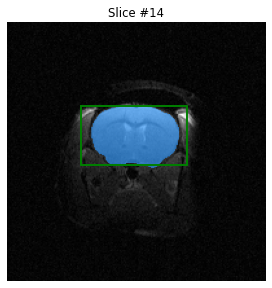

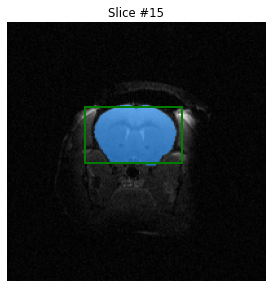

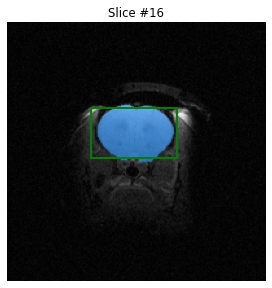

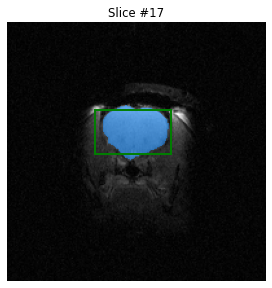

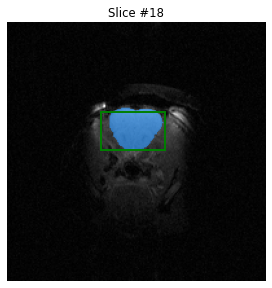

In [5]:
# Save the masks as NIfTI files in the designated output path
for file in files:
    print("\n-------------------------------------------------\n")
    print("Subject filename: ",file,"\n")
    create_sam_masks_nifti(file,list_of_sam_mask_lists[files.index(file)])

## Semi-Auto

List of files to segment:

merge_C230524_ses-01_run-02_T2w.nii.gz

-------------------------------------------------

Subject filename:  merge_C230524_ses-01_run-02_T2w.nii.gz 

✅ Automatic generation of input boxes completed in 0.01 minutes
✅  [◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼] 100.0%  - extraction completed in 0.14 minutes


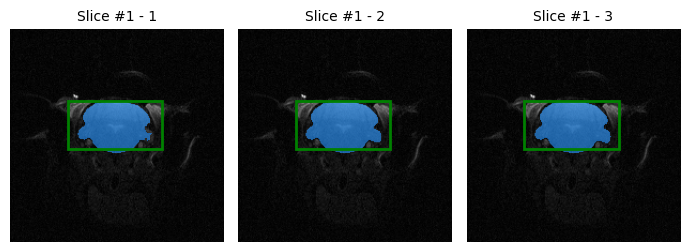

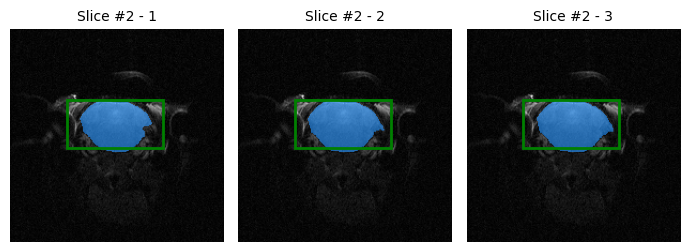

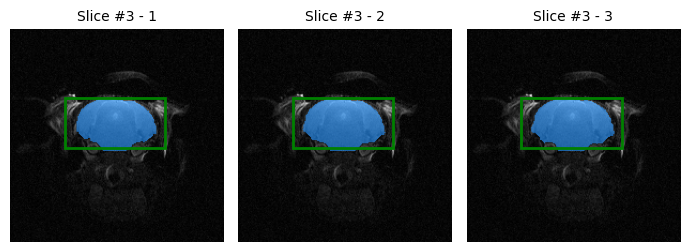

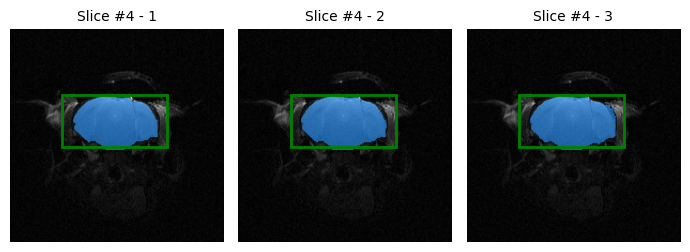

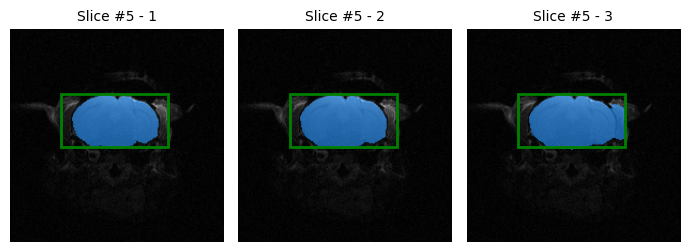

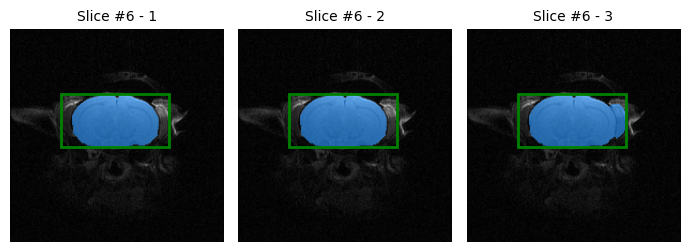

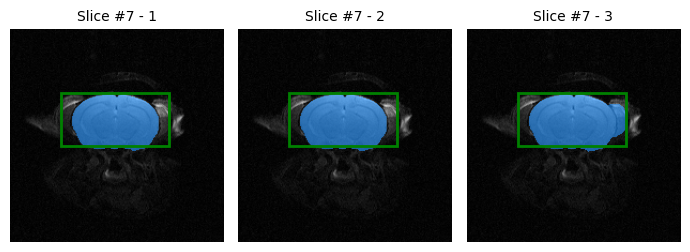

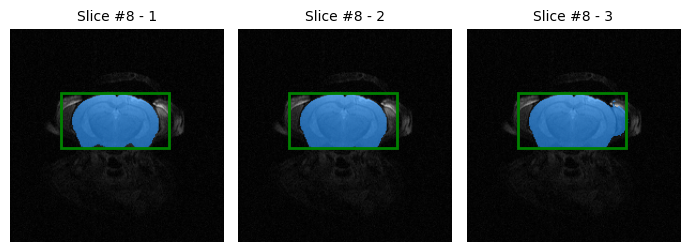

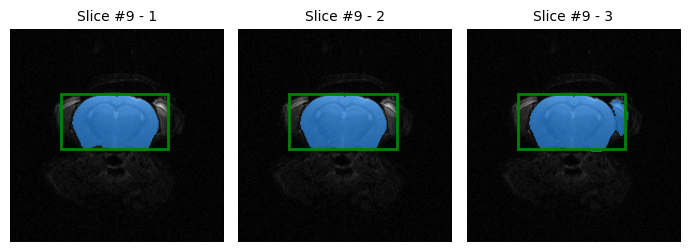

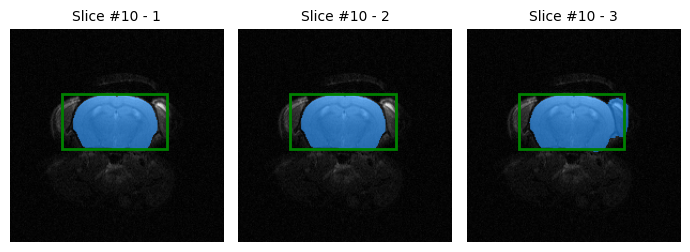

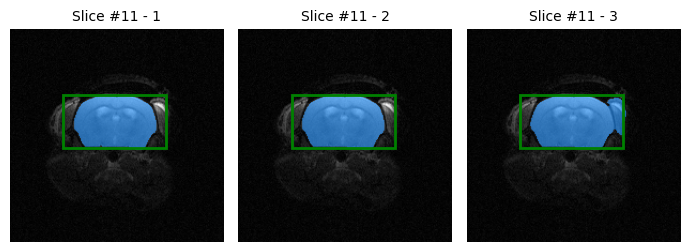

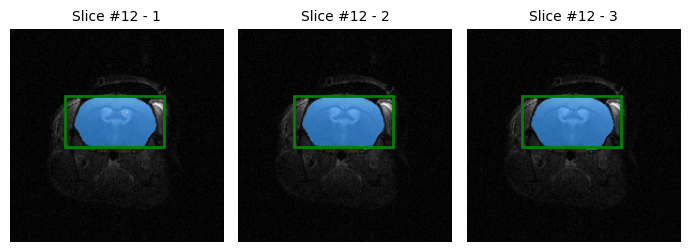

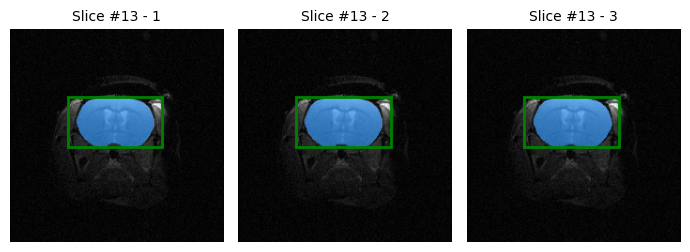

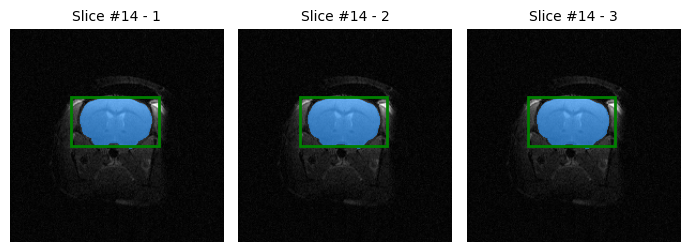

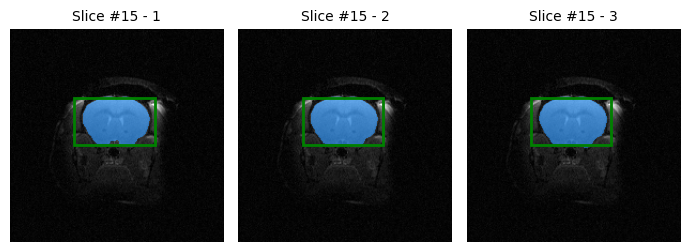

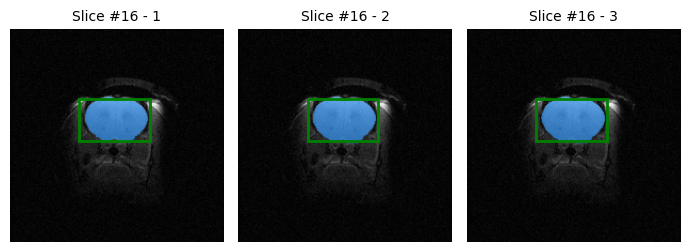

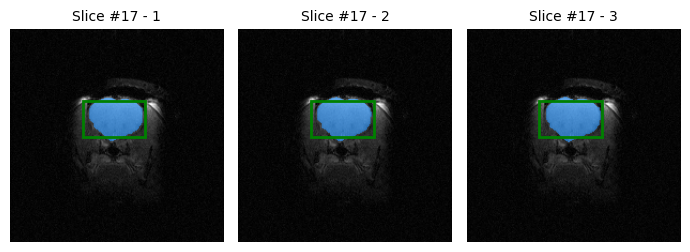

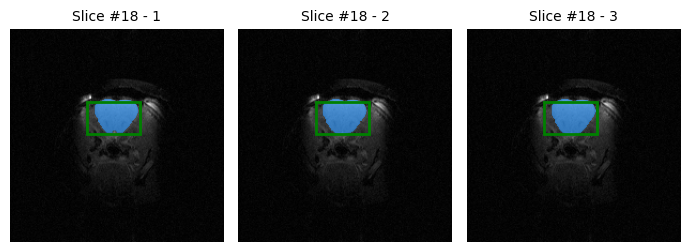

In [6]:
# Create a list of image files for segmentation
files = []
subjects_path, output_path = subjects_path, pjoin(output_path_b,"semi_auto")
os.makedirs(pjoin(output_path), exist_ok=True)
print("List of files to segment:\n")
for file in sorted(os.listdir(subjects_path)):
    if file.endswith("nii") or file.endswith("nii.gz"):  # Adapt filename conditions
        files.append(file)
        print(file)

# Generate SAMson masks and visualize the corresponding predictions
list_of_sam_mask_lists = []

for file in files:
    print("\n-------------------------------------------------\n")
    print("Subject filename: ",file,"\n")
    sam_mask_list = create_sam_candidates_list(file, semi_auto=True)    
    list_of_sam_mask_lists.append(sam_mask_list)

In [7]:
# The following step requires a reference mask
#best_mask_indexes = find_best_mask_indexes(jaccards_per_slice, len(files[:1]), 16)

# Otherwise, manually specify the optimal output indices for each slice as follows:
# best_mask_indexes = [[0,1,2,1,2,0,...],
#                             ...       ,
#                      [...............]]
best_mask_indexes = [[1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]]  

best_mask_indexes

[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]


-------------------------------------------------

Subject filename:  merge_C230524_ses-01_run-02_T2w.nii.gz 



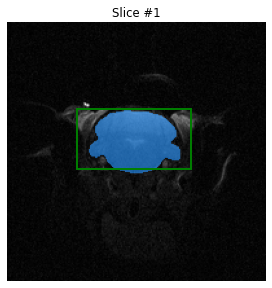

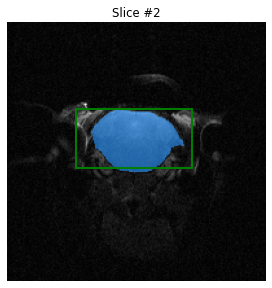

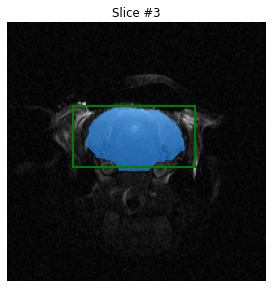

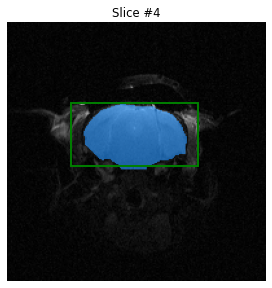

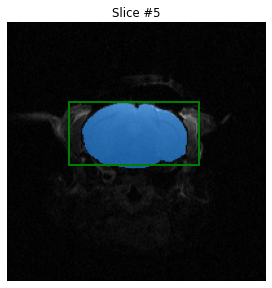

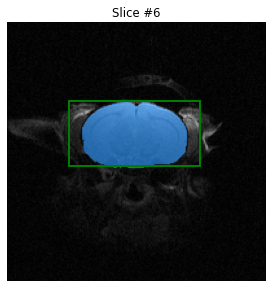

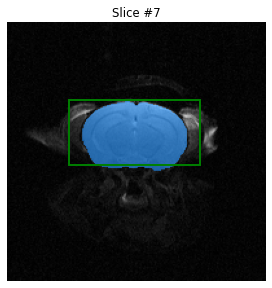

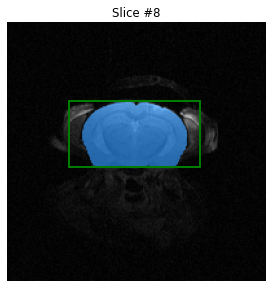

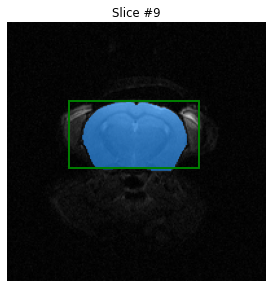

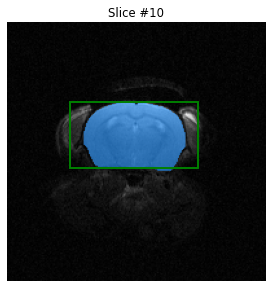

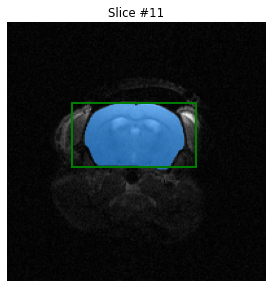

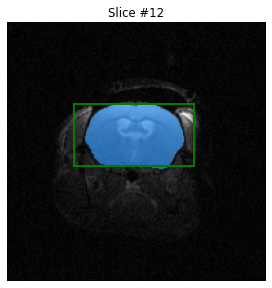

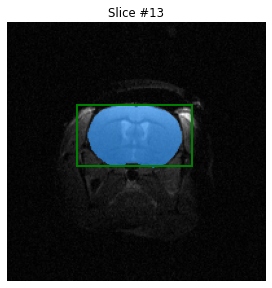

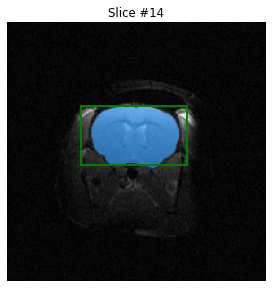

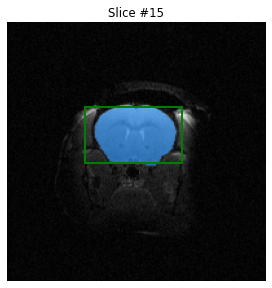

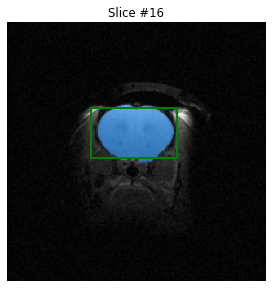

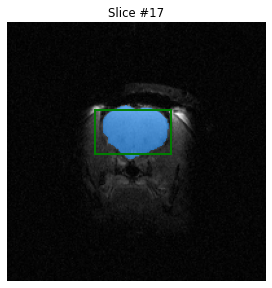

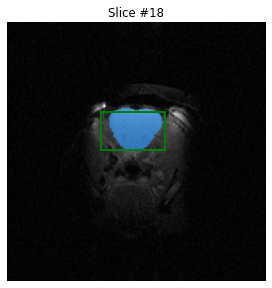

In [8]:
# Save the masks as NIfTI files in the designated output path
for file in files: 
    print("\n-------------------------------------------------\n")
    print("Subject filename: ",file,"\n")
    create_sam_masks_nifti(file,list_of_sam_mask_lists[files.index(file)],best_mask_index=best_mask_indexes[files.index(file)])

## Accuracy analysis

In this section, we demonstrate the segmentation of images with existing manual masks, utilizing the evaluation functions for analysis.

In [9]:
subjects_path = r"/home/dpanadero/Documents/data/d1/3_months"  # Folder with already extracted files to show evaluation
# Remember to adjust the anteroposterior range for correct input prompt generation
initial_slice =  4  
final_slice   = 33  

### Full-Auto

List of files to segment:

T2Wmice_first_im_A110123_3mo_.nii
T2Wmice_first_im_A120123_3mo_.nii
T2Wmice_first_im_A130123_3mo_.nii
T2Wmice_first_im_A160123_3mo_.nii
T2Wmice_first_im_A170123_3mo_.nii
T2Wmice_first_im_B110123_3mo_.nii
T2Wmice_first_im_B120123_3mo_.nii
T2Wmice_first_im_B130123_3mo_.nii
T2Wmice_first_im_B160123_3mo_.nii
T2Wmice_first_im_B170123_3mo_.nii
T2Wmice_first_im_C110123_3mo_.nii
T2Wmice_first_im_C120123_3mo_.nii
T2Wmice_first_im_C130123_3mo_.nii
T2Wmice_first_im_C160123_3mo_.nii
T2Wmice_first_im_D120123_3mo_.nii
T2Wmice_first_im_D160123_3mo_.nii

-------------------------------------------------

Subject filename:  T2Wmice_first_im_A110123_3mo_.nii 

✅ Automatic generation of input boxes completed in 0.01 minutes
✅  [◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼] 100.0%  - extraction completed in 0.13 minutes
	1: 61.28%	

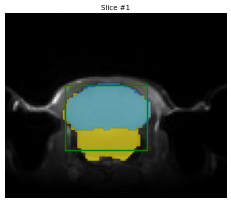

	2: 69.66%	

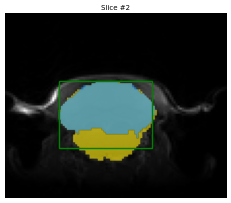

	3: 96.36%	

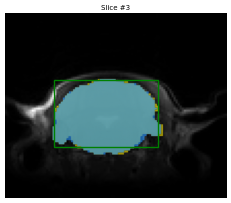

	4: 93.6%	

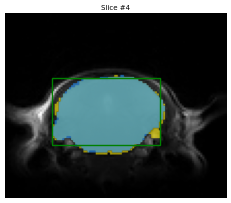

	5: 96.43%	

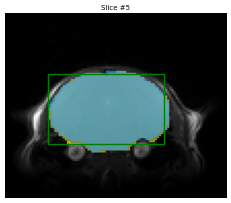

	6: 96.93%	

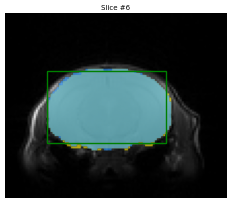

	7: 95.28%	

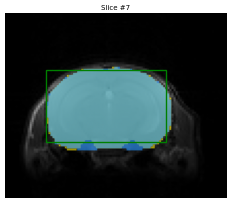

	8: 96.16%	

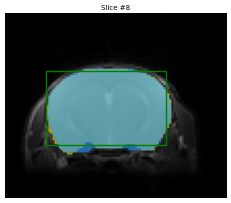

	9: 96.65%	

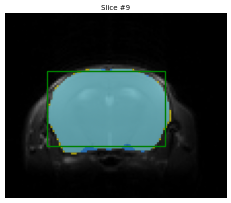

	10: 96.33%	

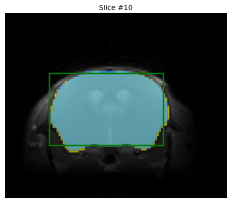

	11: 96.83%	

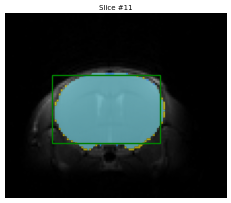

	12: 97.3%	

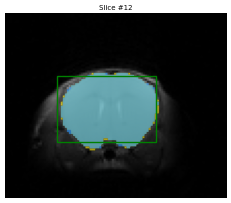

	13: 93.18%	

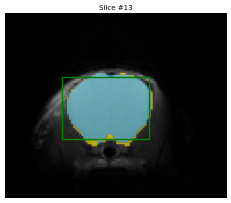

	14: 89.97%	

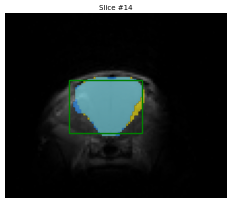

	15: 89.63%	

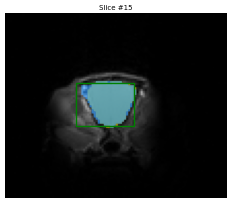

	16: 90.59%	

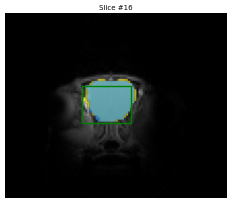

Subject mean performance metrics:
Accuracy:		 91.01%
Jaccard index:		 0.912
Dice coefficient:	 0.9508

ALL SUBJECTS PERFORMANCE METRICS:
Mean values per subject:
Accuracy: 		[91.01]
Jaccard index: 		[0.912]
Dice coefficient: 	[0.9508]

Values of all slice masks:
Accuracy: 		[61.28, 69.66, 96.36, 93.6, 96.43, 96.93, 95.28, 96.16, 96.65, 96.33, 96.83, 97.3, 93.18, 89.97, 89.63, 90.59]
Jaccard index: 		[0.622, 0.6975, 0.9641, 0.937, 0.9648, 0.9697, 0.9544, 0.9625, 0.9671, 0.9636, 0.9685, 0.9732, 0.9323, 0.9037, 0.905, 0.9072]
Dice coefficient: 	[0.767, 0.8218, 0.9817, 0.9675, 0.9821, 0.9846, 0.9767, 0.9809, 0.9833, 0.9815, 0.984, 0.9864, 0.9649, 0.9494, 0.9501, 0.9513]


In [10]:
# Create a list of image files for segmentation
files = []
output_path = pjoin(output_path_b,"full_auto/3_months")
os.makedirs(pjoin(output_path), exist_ok=True)
print("List of files to segment:\n")
for file in sorted(os.listdir(subjects_path)):
    if file.startswith("T2Wmice_first_im") and file.endswith("nii"):  # Adapt filename conditions
        files.append(file)
        print(file)

accuracies_per_slice = []
jaccards_per_slice   = []
dices_per_slice      = []
mean_accuracies = []
mean_jaccards   = []
mean_dices      = []

# Generate SAMson masks and visualize the corresponding predictions
list_of_sam_mask_lists = []

for file in files[:1]:  # Only first file
    print("\n-------------------------------------------------\n")
    print("Subject filename: ",file,"\n")
    sam_mask_list = create_sam_candidates_list(file, reference_mask=True, reorient=False)    
    list_of_sam_mask_lists.append(sam_mask_list)


print("\nALL SUBJECTS PERFORMANCE METRICS:")
print("Mean values per subject:")
print(f"Accuracy: \t\t{mean_accuracies}")
print(f"Jaccard index: \t\t{mean_jaccards}")
print(f"Dice coefficient: \t{mean_dices}")
print("\nValues of all slice masks:")
print(f"Accuracy: \t\t{accuracies_per_slice}")
print(f"Jaccard index: \t\t{jaccards_per_slice}")
print(f"Dice coefficient: \t{dices_per_slice}")


-------------------------------------------------

Subject filename:  T2Wmice_first_im_A110123_3mo_.nii 

Accuracy of slice #1: 61.28%


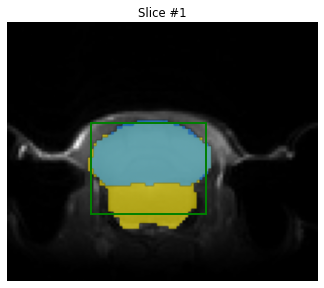

Accuracy of slice #2: 69.66%


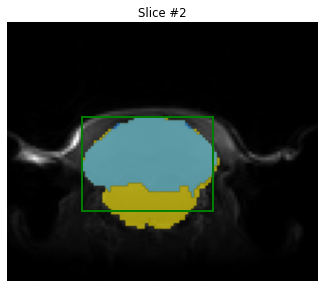

Accuracy of slice #3: 96.36%


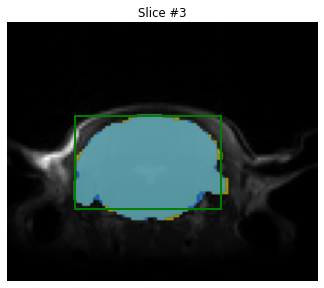

Accuracy of slice #4: 93.6%


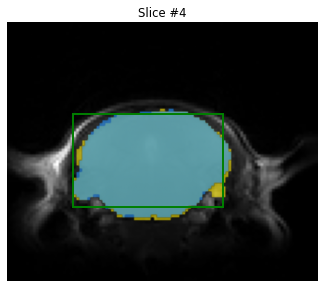

Accuracy of slice #5: 96.43%


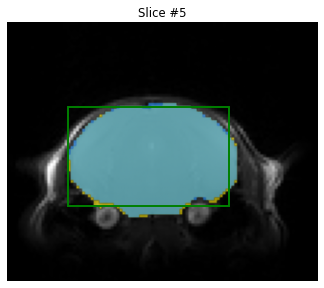

Accuracy of slice #6: 96.93%


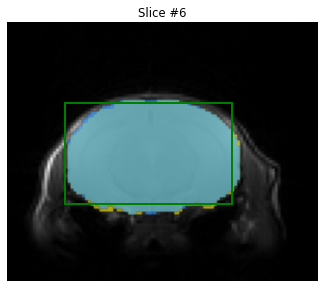

Accuracy of slice #7: 95.28%


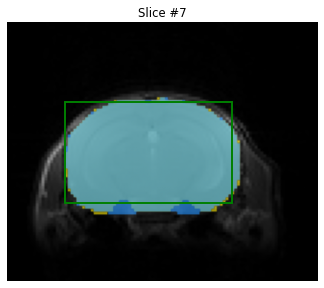

Accuracy of slice #8: 96.16%


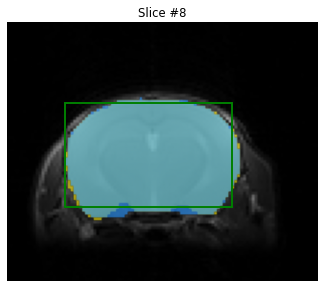

Accuracy of slice #9: 96.65%


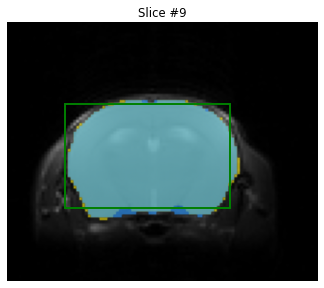

Accuracy of slice #10: 96.33%


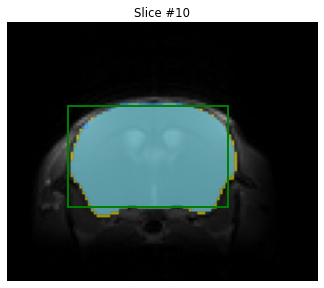

Accuracy of slice #11: 96.83%


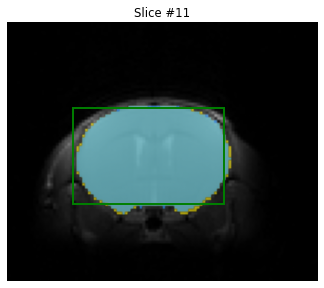

Accuracy of slice #12: 97.3%


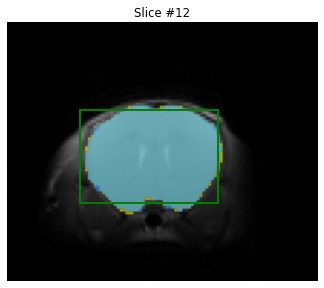

Accuracy of slice #13: 93.18%


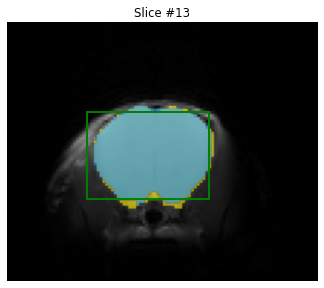

Accuracy of slice #14: 89.97%


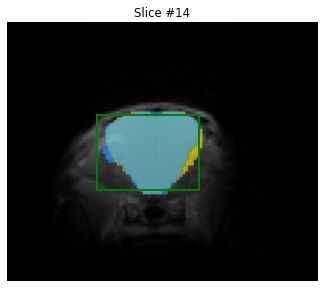

Accuracy of slice #15: 89.63%


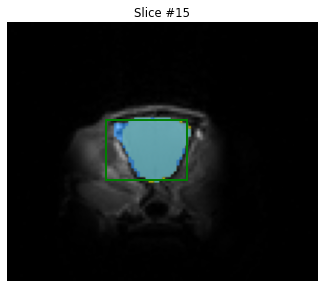

Accuracy of slice #16: 90.59%


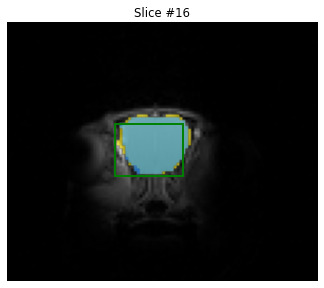

Subject mean performance metrics:
Accuracy:		 91.01%
Jaccard index:		 0.912
Dice coefficient:	 0.9508


In [11]:
# Save the masks as NIfTI files in the designated output path
for file in files[:1]:  # Only first file
    print("\n-------------------------------------------------\n")
    print("Subject filename: ",file,"\n")
    create_sam_masks_nifti(file,list_of_sam_mask_lists[files.index(file)],reference_mask=True,reorient=False)

### Semi-Auto

List of files to segment:

T2Wmice_first_im_A110123_3mo_.nii
T2Wmice_first_im_A120123_3mo_.nii
T2Wmice_first_im_A130123_3mo_.nii
T2Wmice_first_im_A160123_3mo_.nii
T2Wmice_first_im_A170123_3mo_.nii
T2Wmice_first_im_B110123_3mo_.nii
T2Wmice_first_im_B120123_3mo_.nii
T2Wmice_first_im_B130123_3mo_.nii
T2Wmice_first_im_B160123_3mo_.nii
T2Wmice_first_im_B170123_3mo_.nii
T2Wmice_first_im_C110123_3mo_.nii
T2Wmice_first_im_C120123_3mo_.nii
T2Wmice_first_im_C130123_3mo_.nii
T2Wmice_first_im_C160123_3mo_.nii
T2Wmice_first_im_D120123_3mo_.nii
T2Wmice_first_im_D160123_3mo_.nii

-------------------------------------------------

Subject filename:  T2Wmice_first_im_A110123_3mo_.nii 

✅ Automatic generation of input boxes completed in 0.01 minutes
✅  [◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼] 100.0%  - extraction completed in 0.13 minutes
	1: 60.19%		1: 93.43%		1: 95.45%	

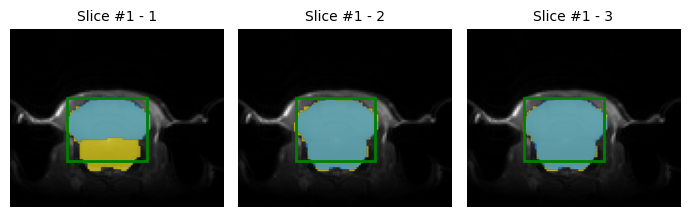

	2: 63.9%		2: 81.99%		2: 95.74%	

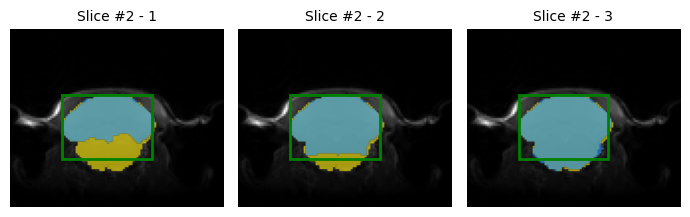

	3: 79.97%		3: 96.29%		3: 94.88%	

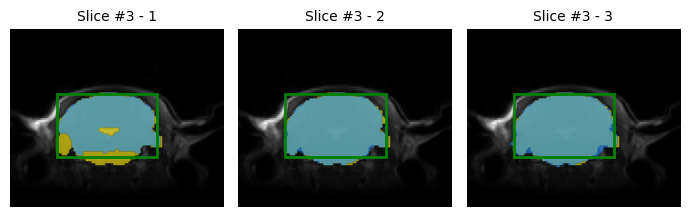

	4: 91.14%		4: 93.23%		4: 91.88%	

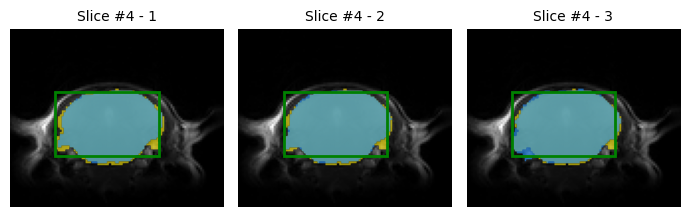

	5: 95.83%		5: 96.43%		5: 95.77%	

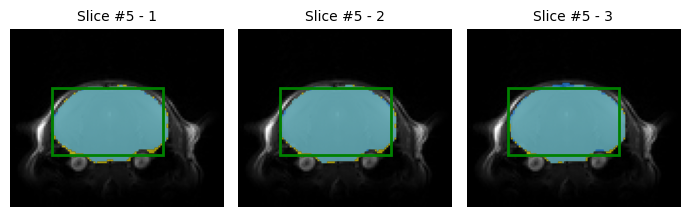

	6: 96.33%		6: 97.23%		6: 95.57%	

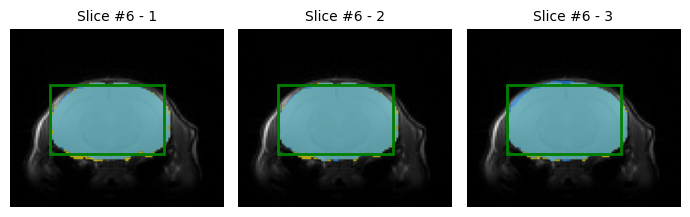

	7: 90.91%		7: 95.28%		7: 95.19%	

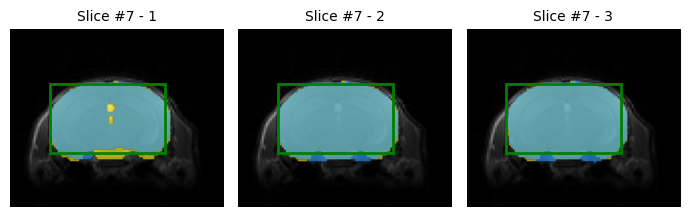

	8: 96.01%		8: 96.11%		8: 95.58%	

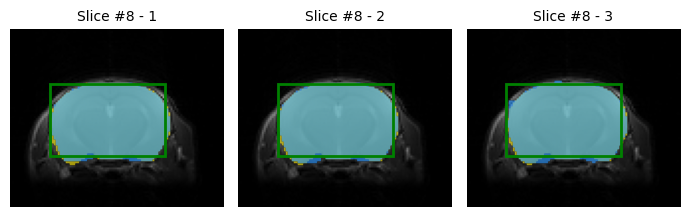

	9: 95.81%		9: 96.7%		9: 96.35%	

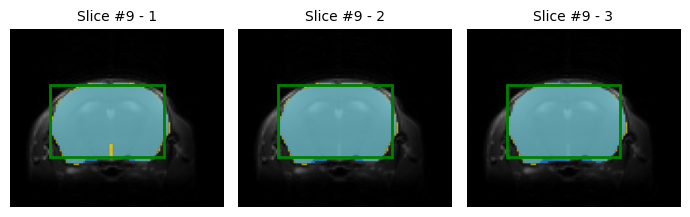

	10: 96.11%		10: 96.33%		10: 96.27%	

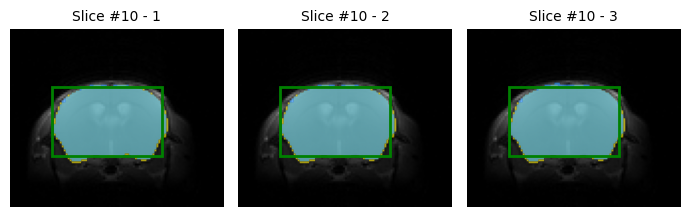

	11: 96.28%		11: 96.59%		11: 96.77%	

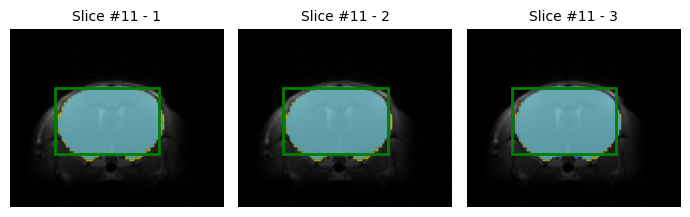

	12: 95.38%		12: 96.8%		12: 97.23%	

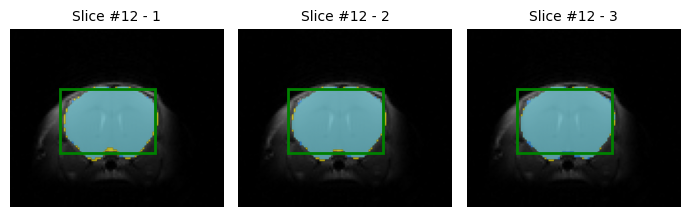

	13: 43.39%		13: 93.01%		13: 95.65%	

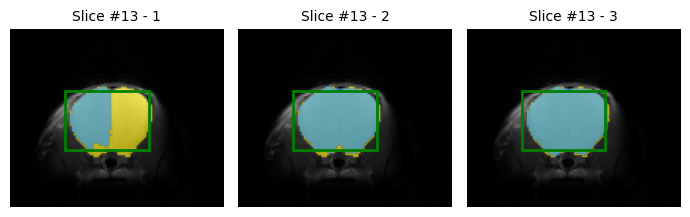

	14: 87.36%		14: 90.66%		14: 87.09%	

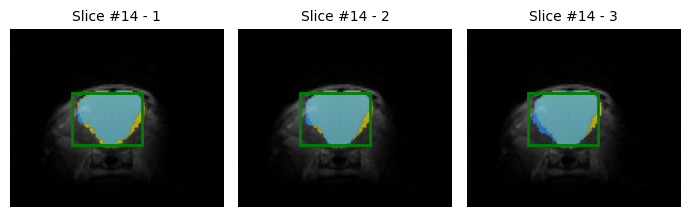

	15: 93.58%		15: 89.38%		15: 84.44%	

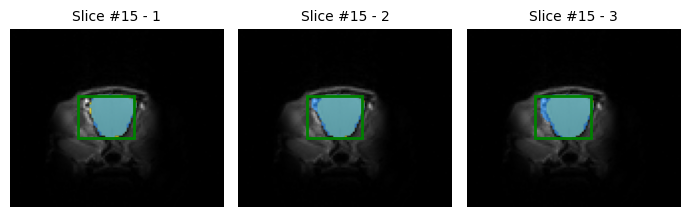

	16: 89.88%		16: 90.35%		16: 90.59%	

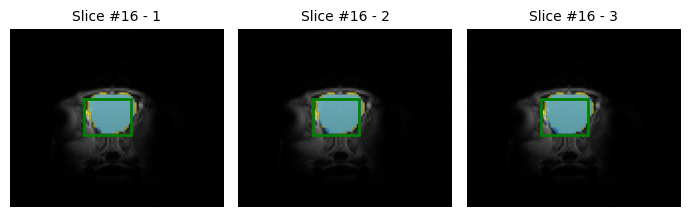

Subject mean performance metrics:
Accuracy:		 91.17%
Jaccard index:		 0.9135
Dice coefficient:	 0.9512


In [12]:
# Create a list of image files for segmentation
files = []
output_path = pjoin(output_path_b,"semi_auto/3_months")
os.makedirs(pjoin(output_path), exist_ok=True)
print("List of files to segment:\n")
for file in sorted(os.listdir(subjects_path)):
    if file.startswith("T2Wmice_first_im") and file.endswith("nii"):  # Adapt filename conditions
        files.append(file)
        print(file)

accuracies_per_slice = []
jaccards_per_slice   = []
dices_per_slice      = []
mean_accuracies = []
mean_jaccards   = []
mean_dices      = []

# Generate SAMson masks and visualize the corresponding predictions
list_of_sam_mask_lists = []

for file in files[:1]:  # Only first file
    print("\n-------------------------------------------------\n")
    print("Subject filename: ",file,"\n")
    sam_mask_list = create_sam_candidates_list(file, semi_auto=True, reference_mask=True, reorient=False)
    list_of_sam_mask_lists.append(sam_mask_list)
    

In [13]:
# The following step requires a reference mask
best_mask_indexes = find_best_mask_indexes(jaccards_per_slice, len(files[:1]), 16)

# Otherwise, manually specify the optimal output indices for each slice as follows:
# best_mask_indexes = [[0,1,2,1,2,0,...],
#                             ...       ,
#                      [...............]]

best_mask_indexes

[[2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 0, 2]]


-------------------------------------------------

Subject filename:  T2Wmice_first_im_A110123_3mo_.nii 

Accuracy of slice #1: 95.45%


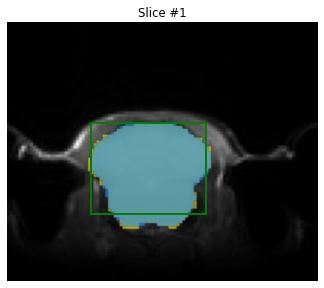

Accuracy of slice #2: 95.74%


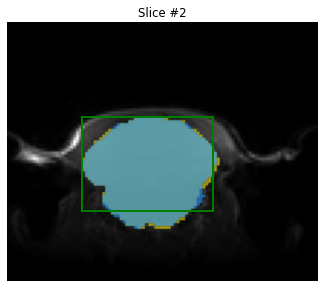

Accuracy of slice #3: 96.29%


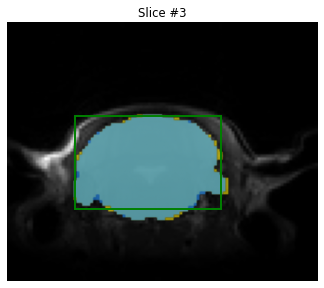

Accuracy of slice #4: 93.23%


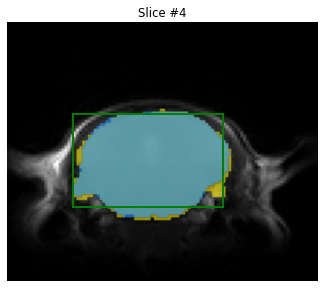

Accuracy of slice #5: 96.43%


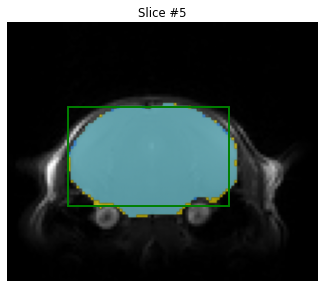

Accuracy of slice #6: 97.23%


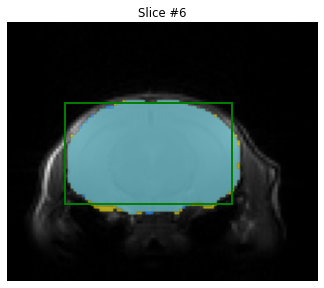

Accuracy of slice #7: 95.28%


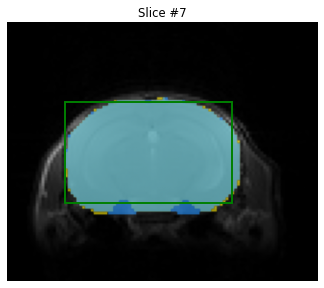

Accuracy of slice #8: 96.11%


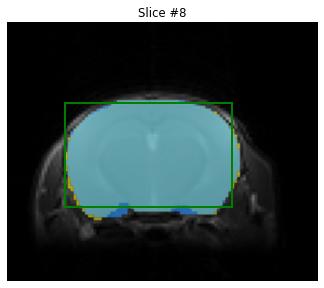

Accuracy of slice #9: 96.7%


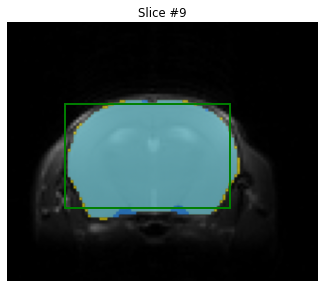

Accuracy of slice #10: 96.33%


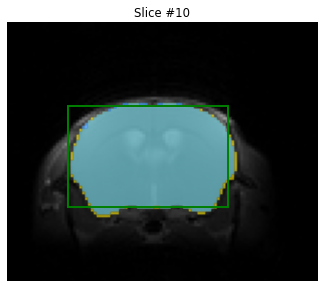

Accuracy of slice #11: 96.77%


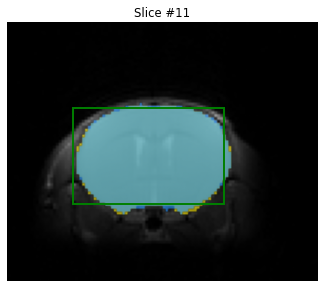

Accuracy of slice #12: 97.23%


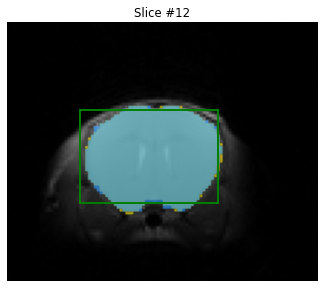

Accuracy of slice #13: 95.65%


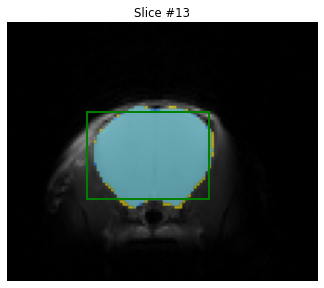

Accuracy of slice #14: 90.66%


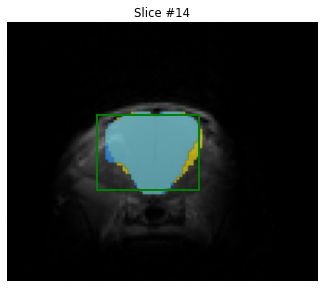

Accuracy of slice #15: 93.58%


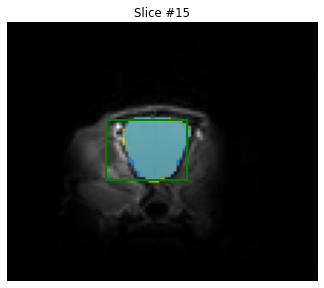

Accuracy of slice #16: 90.59%


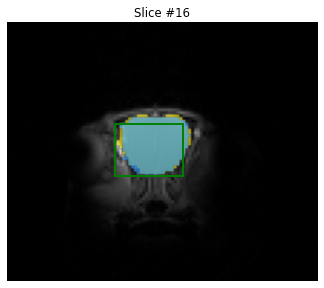

Subject mean performance metrics:
Accuracy:		 95.2%
Jaccard index:		 0.9529
Dice coefficient:	 0.9758

ALL SUBJECTS PERFORMANCE METRICS:
Mean values per subject:
Accuracy: 		[95.2]
Jaccard index: 		[0.9529]
Dice coefficient: 	[0.9758]

Values of all slice masks:
Accuracy: 		[95.45, 95.74, 96.29, 93.23, 96.43, 97.23, 95.28, 96.11, 96.7, 96.33, 96.77, 97.23, 95.65, 90.66, 93.58, 90.59]
Jaccard index: 		[0.9553, 0.9581, 0.9633, 0.933, 0.9645, 0.9725, 0.9544, 0.962, 0.9674, 0.9635, 0.9682, 0.9727, 0.9569, 0.909, 0.9378, 0.9085]
Dice coefficient: 	[0.9771, 0.9786, 0.9813, 0.9653, 0.9819, 0.986, 0.9767, 0.9806, 0.9835, 0.9814, 0.9839, 0.9862, 0.978, 0.9523, 0.9679, 0.952]


In [14]:
accuracies_per_slice = []
jaccards_per_slice   = []
dices_per_slice      = []
mean_accuracies = []
mean_jaccards   = []
mean_dices      = []

# Save the masks as NIfTI files in the designated output path
for file in files[:1]:  # Only first file
    print("\n-------------------------------------------------\n")
    print("Subject filename: ",file,"\n")
    create_sam_masks_nifti(file,list_of_sam_mask_lists[files.index(file)],best_mask_index=best_mask_indexes[files.index(file)],reference_mask=True, reorient=False)


print("\nALL SUBJECTS PERFORMANCE METRICS:")
print("Mean values per subject:")
print(f"Accuracy: \t\t{mean_accuracies}")
print(f"Jaccard index: \t\t{mean_jaccards}")
print(f"Dice coefficient: \t{mean_dices}")
print("\nValues of all slice masks:")
print(f"Accuracy: \t\t{accuracies_per_slice}")
print(f"Jaccard index: \t\t{jaccards_per_slice}")
print(f"Dice coefficient: \t{dices_per_slice}")